In [1]:
# rm(list = ls())
setwd("/mnt/c/git_repos/iORD_hepatitis/")
require(tidyverse)
require(data.table)
require(lubridate)
require(foreach)
require(randomcoloR)
require(tidyquant)
require(ggpubr)

Loading required package: tidyverse

Warning message:
“package ‘tidyverse’ was built under R version 4.1.3”
Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 1.0.0
Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”
Warning message:
“package ‘tibble’ was built under R version 4.1.3”
Warning message:
“package ‘tidyr’ was built under R version 4.1.3”
Warning message:
“package ‘readr’ was built under R version 4.1.3”
Warning message:
“package ‘purrr’ was built under R version 4.1.3”
Warning message:
“package ‘dplyr’ was built under R version 4.1.3”
Warning message:
“package ‘stringr’ was built under R version 4.1.3”
Warning message:
“package ‘forcats’ was built under

### Load data

In [2]:
age_df <- fread("data/IORD_ASHep-UE_34_20230120_Attendances.csv") %>%
    mutate(AttendanceStartDate = as.Date(AttendanceStartDate),
           AttendanceEndDate = as.Date(AttendanceEndDate),
           LinkedBirthmonth = as.Date(LinkedBirthmonth)) %>%
    mutate(AttendanceMonth = cut(AttendanceStartDate, breaks = "month"),
           AttendanceTwoMonth = cut(AttendanceStartDate, breaks = "2 months")) %>%
    mutate(age_upon_presentation = time_length(AttendanceStartDate -
                                               LinkedBirthmonth, "year")) %>%
    mutate(age_upon_presentation = floor(age_upon_presentation)) %>% 
    mutate(age_group = case_when(age_upon_presentation < 7 ~ "<7",
                                 age_upon_presentation >= 6 & age_upon_presentation <= 15 ~ "7-15",
                                 age_upon_presentation >= 16 ~ ">15")) %>%
    arrange(AttendanceStartDate) %>%
    filter(AttendanceStartDate < as.Date("2023-01-01"))


micro_df <- fread("data/IORD_ASHep-UE_34_20230120_Microbiology.csv") %>%
    mutate(AttendanceStartDate = as.Date(AttendanceStartDate)) %>%
    left_join(age_df) %>%
    mutate(AttendanceMonth = cut(AttendanceStartDate, breaks = "month"),
           AttendanceTwoMonth = cut(AttendanceStartDate, breaks = "2 months")) %>%
    mutate(AttendanceStartDate = as.Date(AttendanceStartDate),
           AttendanceMonth = as.Date(AttendanceMonth),
           AttendanceTwoMonth = as.Date(AttendanceTwoMonth)) %>%
    filter(AttendanceMonth < as.Date("2023-01-01")) %>%
    rename(MicroTestName = TestName) %>%
    # Parse records
    mutate(BugName = ifelse(BatTestCode %in% c('CV2G', 'CV2G2', 'CV2P', 'CV2Q', 'CV2V', 'RCV2Q', 'RCV2V') &
                            !grepl("not detected| |NONE|indeterminate", ResultFull, ignore.case = T),
                            "SARS-CoV-2", BugName)) %>%
    mutate(BugName = ifelse(grepl("SARS Coronavirus-2", BugName, ignore.case = T), "SARS-CoV-2", BugName)) %>%
    mutate(BugName = ifelse(grepl("Staphy", BugName, ignore.case = T), "Staphylococcus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Strep", BugName, ignore.case = T), "Streptococcus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Candida", BugName, ignore.case = T), "Candida", BugName)) %>%
    mutate(BugName = ifelse(grepl("influenza a|influenza b|flu a|flu b", BugName, ignore.case = T), "Influenza", BugName)) %>%
    mutate(BugName = ifelse(grepl("Escherichia|E. coli", BugName, ignore.case = T), "Escherichia", BugName)) %>%
    mutate(BugName = ifelse(grepl("Enterococcus", BugName, ignore.case = T), "Enterococcus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Klebsiella", BugName, ignore.case = T), "Klebsiella", BugName)) %>%
    mutate(BugName = ifelse(grepl("Acinetobacter", BugName, ignore.case = T), "Acinetobacter", BugName)) %>%
    mutate(BugName = ifelse(grepl("Bacillus", BugName, ignore.case = T), "Bacillus", BugName)) %>%
    mutate(BugName = ifelse(grepl("HAEMOPHILUS", BugName, ignore.case = T), "Haemophilus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Parvimonas", BugName, ignore.case = T), "Parvimonas", BugName)) %>%
    mutate(BugName = ifelse(grepl("Burkholderia", BugName, ignore.case = T), "Burkholderia", BugName)) %>%
    mutate(BugName = ifelse(grepl("Micrococcus", BugName, ignore.case = T), "Micrococcus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Proteus", BugName, ignore.case = T), "Proteus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Lactococcus", BugName, ignore.case = T), "Lactococcus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Adenovirus", BugName, ignore.case = T), "Adenovirus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Rothia", BugName, ignore.case = T), "Rothia", BugName)) %>%
    mutate(BugName = ifelse(grepl("Salmonella", BugName, ignore.case = T), "Salmonella", BugName)) %>%
    mutate(BugName = ifelse(grepl("Actinomyces", BugName, ignore.case = T), "Actinomyces", BugName)) %>%
    mutate(BugName = ifelse(grepl("ANAEROCOCCUS", BugName, ignore.case = T), "Anaerococcus ", BugName)) %>%
    mutate(BugName = ifelse(grepl("Pseudomonas", BugName, ignore.case = T), "Pseudomonas", BugName)) %>%
    mutate(BugName = ifelse(grepl("Corynebacterium", BugName, ignore.case = T), "Corynebacterium", BugName)) %>%
    mutate(BugName = ifelse(grepl("Yersinia", BugName, ignore.case = T), "Yersinia", BugName)) %>%
    mutate(BugName = ifelse(grepl("ASPERGILLUS", BugName, ignore.case = T), "Aspergillus", BugName)) %>%
    mutate(BugName = ifelse(grepl("TURICELLA", BugName, ignore.case = T), "Turicella", BugName)) %>%
    mutate(BugName = ifelse(grepl("serratia", BugName, ignore.case = T), "Serratia", BugName)) %>%
    mutate(BugName = ifelse(grepl("moraxella", BugName, ignore.case = T), "Moraxella", BugName)) %>%
    mutate(BugName = ifelse(grepl("bacteroides", BugName, ignore.case = T), "Bacteroides", BugName)) %>%
    mutate(BugName = ifelse(grepl("shigella", BugName, ignore.case = T), "Shigella", BugName)) %>%
    mutate(BugName = ifelse(grepl("enterobacter", BugName, ignore.case = T), "Enterobacter", BugName)) %>%
    mutate(BugName = ifelse(grepl("GORDONIA", BugName, ignore.case = T), "Gordonia", BugName)) %>%
    mutate(BugName = ifelse(grepl("rhinovirus|enterovirus", BugName, ignore.case = T), "Rhinovirus/Enterovirus", BugName)) %>%
    mutate(BugName = ifelse(grepl("aerococcus", BugName, ignore.case = T), "Aerococcus", BugName)) %>%
    mutate(BugName = ifelse(grepl("aeromonas", BugName, ignore.case = T), "Aeromonas", BugName)) %>%
    mutate(BugName = ifelse(grepl("Raoultella", BugName, ignore.case = T), "Raoultella", BugName)) %>%
    mutate(BugName = ifelse(grepl("Brevibacterium", BugName, ignore.case = T), "Brevibacterium", BugName)) %>%
    mutate(BugName = ifelse(grepl("Prevotella", BugName, ignore.case = T), "Prevotella", BugName)) %>%
    mutate(BugName = ifelse(grepl("Trichophyton", BugName, ignore.case = T), "Trichophyton", BugName)) %>%
    mutate(BugName = ifelse(grepl("Parainfluenzavirus|parainfluenza virus", BugName, ignore.case = T), "Parainfluenzavirus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Clostridium", BugName, ignore.case = T), "Clostridium", BugName)) %>%
    mutate(BugName = ifelse(grepl("Neisseria", BugName, ignore.case = T), "Neisseria", BugName)) %>%
    mutate(BugName = ifelse(grepl("Fusobacterium", BugName, ignore.case = T), "Fusobacterium", BugName)) %>%
    mutate(BugName = ifelse(grepl("Atopobium", BugName, ignore.case = T), "Atopobium", BugName)) %>%
    mutate(BugName = ifelse(grepl("Aggregatibacter", BugName, ignore.case = T), "Aggregatibacter", BugName)) %>%
    mutate(BugName = ifelse(grepl("Sphingobacterium", BugName, ignore.case = T), "Sphingobacterium", BugName)) %>%
    mutate(BugName = ifelse(grepl("Bradyrhizobium", BugName, ignore.case = T), "Bradyrhizobium", BugName)) %>%
    mutate(BugName = ifelse(grepl("Ruminococcus", BugName, ignore.case = T), "Ruminococcus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Alcaligenes", BugName, ignore.case = T), "Alcaligenes", BugName)) %>%
    mutate(BugName = ifelse(grepl("Paracoccus", BugName, ignore.case = T), "Paracoccus", BugName)) %>%
    mutate(BugName = ifelse(grepl("HAEMATOBACTER", BugName, ignore.case = T), "Haematobacter", BugName)) %>%
    mutate(BugName = ifelse(grepl("Microbacterium", BugName, ignore.case = T), "Microbacterium", BugName)) %>%
    mutate(BugName = ifelse(grepl("Mycobacterium", BugName, ignore.case = T), "Mycobacterium", BugName)) %>%
    mutate(BugName = ifelse(grepl("Citrobacter", BugName, ignore.case = T), "Citrobacter", BugName)) %>%
    mutate(BugName = ifelse(grepl("Propionibacterium", BugName, ignore.case = T), "Cutibacterium", BugName)) %>%
    mutate(BugName = ifelse(grepl("Respiratory Syncytial Virus", BugName, ignore.case = T), "RSV", BugName)) %>%
    mutate(BugName = ifelse(grepl("Herpes|varicella", BugName, ignore.case = T), "Herpesvirus", BugName)) %>%
    mutate(BugName = ifelse(grepl("ACHROMOBACTER", BugName, ignore.case = T), "Achromobacter", BugName)) %>%
    mutate(BugName = ifelse(grepl("Kocuria", BugName, ignore.case = T), "Kocuria", BugName)) %>%
    mutate(BugName = ifelse(grepl("Roseomonas", BugName, ignore.case = T), "Roseomonas", BugName)) %>%
    mutate(BugName = ifelse(grepl("Morganella", BugName, ignore.case = T), "Morganella", BugName)) %>%
    mutate(BugName = ifelse(grepl("Listeria", BugName, ignore.case = T), "Listeria", BugName)) %>%
    mutate(BugName = ifelse(grepl("Chlamydia", BugName, ignore.case = T), "Cutibacterium", BugName)) %>%
    mutate(BugName = ifelse(grepl("Stenotrophomonas", BugName, ignore.case = T), "Stenotrophomonas", BugName)) %>%
    mutate(BugName = ifelse(grepl("Sphingomonas", BugName, ignore.case = T), "Sphingomonas", BugName)) %>%
    mutate(BugName = ifelse(grepl("VEILLONELLA", BugName, ignore.case = T), "Veillonella", BugName)) %>%
    mutate(BugName = ifelse(grepl("Finegoldia", BugName, ignore.case = T), "Finegoldia", BugName)) %>%
    mutate(BugName = ifelse(grepl("Pasteurella", BugName, ignore.case = T), "Pasteurella", BugName)) %>%
    mutate(BugName = ifelse(grepl("Campylobacter", BugName, ignore.case = T), "Campylobacter", BugName)) %>%
    mutate(BugName = ifelse(grepl("Rhizobium", BugName, ignore.case = T), "Rhizobium", BugName)) %>%
    mutate(BugName = ifelse(grepl("PEPTONIPHILUS", BugName, ignore.case = T), "Peptoniphilus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Brevundimonas", BugName, ignore.case = T), "Brevundimonas", BugName)) %>%
    mutate(BugName = ifelse(grepl("GEMELLA", BugName, ignore.case = T), "Gemella", BugName)) %>%
    mutate(BugName = ifelse(grepl("cocci|colonies|aerobic|anaerobic|anaerobes|gram positive|gram negative|Fungal", BugName, ignore.case = T), "ambiguous", BugName))

test_df <- fread("data/IORD_ASHep-UE_34_20230120_LIMS.csv") %>%
    mutate(CollectionDateTime = as.Date(CollectionDateTime),
           AttendanceStartDate = as.Date(AttendanceStartDate)) %>%
    filter(AttendanceStartDate < as.Date("2023-01-01"))

Joining with `by = join_by(ClusterID, AttendanceStartDate)`
Warning message in left_join(., age_df):
“Each row in `x` is expected to match at most 1 row in `y`.
ℹ Row 93 of `x` matches multiple rows.
ℹ If multiple matches are expected, set `multiple = "all"` to silence this warning.”


In [8]:
age_filt <- age_df %>%
    distinct(AttendanceStartDate, ClusterID, .keep_all = T) %>%
    mutate(AttendanceMonth = as.Date(AttendanceMonth))

`summarise()` has grouped output by 'ClusterID', 'AttendanceStartDate'. You can override using the `.groups` argument.
Joining with `by = join_by(ClusterID, AttendanceStartDate, AttendanceMonth)`
`summarise()` has grouped output by 'AttendanceMonth'. You can override using the `.groups` argument.


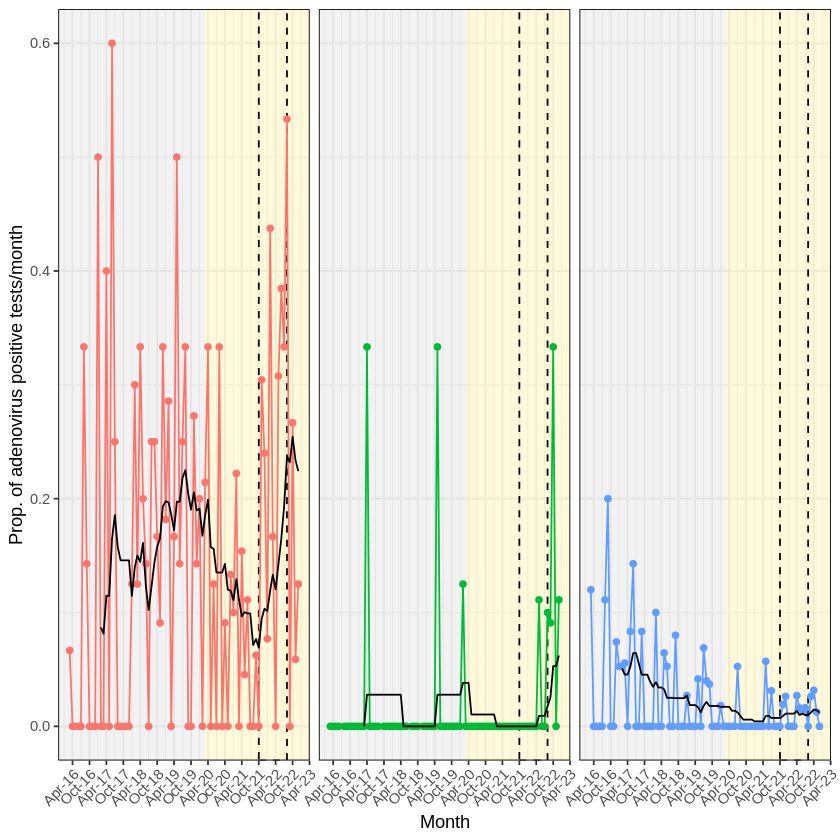

In [11]:
adeno_tests <- micro_df %>%
    filter(grepl("adeno", BugName, ignore.case = T)) %>%
    distinct(BatTestCode)

micro_filt <- micro_df %>%
    filter(BatTestCode %in% adeno_tests$BatTestCode) %>%
    distinct(ClusterID, AttendanceStartDate, BugName, .keep_all = T) %>%
    mutate(adeno_pos = ifelse(grepl("adeno", BugName, ignore.case = T), T, F)) %>%
    mutate(age_group = factor(age_group, c("<7", "7-15", ">15")))

# Code multiple tests
multi_filt <- micro_filt %>%
    group_by(ClusterID, AttendanceStartDate, AttendanceMonth) %>%
    summarise(n_pos = sum(adeno_pos)) %>%
    mutate(adeno_pos = ifelse(n_pos > 0, T, F))

micro_plot_df <- multi_filt %>%
    inner_join(age_filt) %>%
    group_by(AttendanceMonth, age_group) %>%
    summarise(pos_rate = sum(adeno_pos) / n_distinct(ClusterID, AttendanceStartDate),
              n_tests = n_distinct(ClusterID, AttendanceStartDate)) %>%
    mutate(age_group = factor(age_group, c("<7", "7-15", ">15")))

# micro_plot_df <- all_months_df %>%
#     left_join(micro_plot_df) %>%
#     mutate(pos_rate = ifelse(is.na(pos_rate), 0, pos_rate),
#            n_tests = ifelse(is.na(n_tests), 0, n_tests))

plt1 <- micro_plot_df %>%
    ggplot(aes(x = AttendanceMonth, y = pos_rate, color = age_group)) +
        annotate("rect",
         xmin = as.Date(-Inf), xmax = as.Date("2020-03-01"), 
         ymin = -Inf, ymax = Inf,
         fill = "grey83",
         alpha = 0.3) +
        annotate("rect",
                 xmin = as.Date("2020-03-01"), xmax = as.Date(Inf), 
                 ymin = -Inf, ymax = Inf,
                 fill = "lightgoldenrod1",
                 alpha = 0.3) +
        annotate("rect",
             xmin = as.Date("2021-10-01"), xmax = as.Date("2022-08-01"), 
             ymin = -Inf, ymax = Inf,
             fill = NA,
             color = "black",
             lty = "dashed",
             alpha = 0.3) +
        geom_line() +
        geom_point() +
        geom_ma(ma_fun = SMA, n = 12, color = "black", lty = 1) +
        theme_bw() +
        labs(x = "Month", y = "Prop. of adenovirus positive tests/month",
              color = "Age group") +
        facet_grid(cols = vars(age_group), 
                   scales = "free") +
        scale_x_date(date_labels="%b-%y", date_breaks  = "6 month") +
        theme(axis.text.x = element_text(angle = 45, hjust = 1),
              panel.border = element_rect(color = "black", fill = NA),
              legend.position = "none",
              strip.background = element_blank(),
              strip.text = element_blank())
plt1
# ggsave("results/prop_pos_tests.pdf", dpi = 600, width = 20, height = 3)

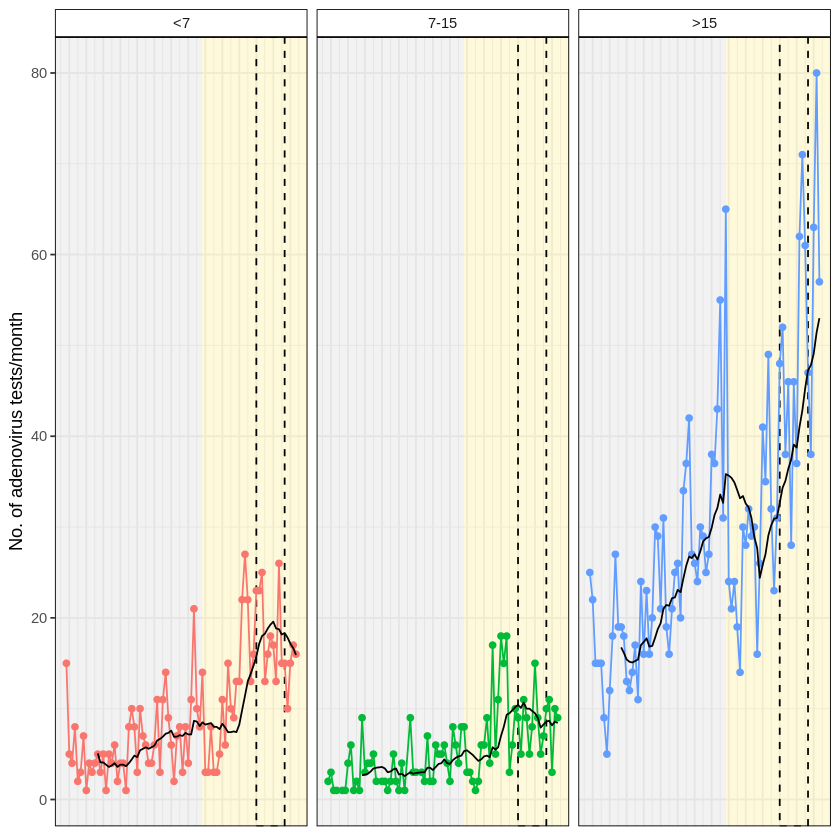

In [12]:
plt2 <- micro_plot_df %>%
    ggplot(aes(AttendanceMonth, n_tests, color = age_group)) +
        annotate("rect",
         xmin = as.Date(-Inf), xmax = as.Date("2020-03-01"), 
         ymin = -Inf, ymax = Inf,
         fill = "grey83",
         alpha = 0.3) +
        annotate("rect",
                 xmin = as.Date("2020-03-01"), xmax = as.Date(Inf), 
                 ymin = -Inf, ymax = Inf,
                 fill = "lightgoldenrod1",
                 alpha = 0.3) +
        annotate("rect",
             xmin = as.Date("2021-10-01"), xmax = as.Date("2022-08-01"), 
             ymin = -Inf, ymax = Inf,
             fill = NA,
             color = "black",
             lty = "dashed",
             alpha = 0.3) +
        geom_point() +
        geom_line() +
        geom_ma(ma_fun = SMA, n = 12, color = "black", lty = 1) +
        labs(x = "Month", y = "No. of adenovirus tests/month",
              color = "Age group") +
        facet_grid(cols = vars(age_group), 
                   scales = "free") +
        scale_x_date(date_labels="%b-%y", date_breaks  = "6 month") +
        theme_bw() +
        theme(axis.text.x = element_blank(),
              axis.ticks.x = element_blank(),
              axis.title.x = element_blank(),
              legend.position = "none",
              strip.background = element_rect(fill = "white", color = "black"),
              panel.border = element_rect(color = "black", fill = NA))
plt2
# ggsave("results/n_adeno_tests.big.pdf", plot = plt2, dpi = 600, width = 25, height = 3)

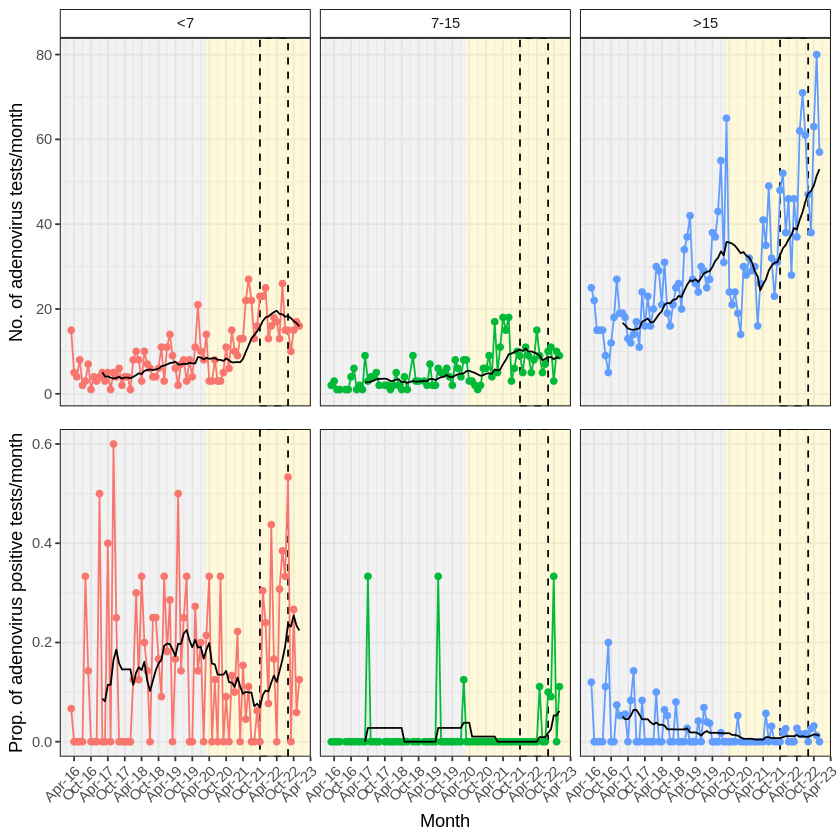

In [13]:
ggpubr::ggarrange(plt2, plt1, nrow = 2, align = "v")

ggsave("results/multi_adeno_tests.pdf", dpi = 600, width = 12, height = 8)
# ggsave("results/multi_adeno_tests.big.pdf", dpi = 600, width = 12, height = 8)

In [16]:
micro_plot_df %>%
    ungroup() %>%
    summarise(min = min(AttendanceMonth), max = max(AttendanceMonth))

min,max
<date>,<date>
2016-03-01,2022-12-01


In [17]:
micro_filt %>%
    group_by(age_group) %>%
    summarise(n = n())

age_group,n
<fct>,<int>
<7,935
7-15,448
>15,2588


### Adeno-positive tests within and outside AS-Hep-UA outbreak

In [20]:
adeno_tests

BatTestCode
<chr>
RPCR
EPCR
OPCR
RGAS
LRTP


In [24]:
adeno_df %>%
    mutate(epoch = case_when(AttendanceStartDate < ""))
    group_by(age_group, epoch) %>%
    summarise(n = n(),
              n_pos = sum(adeno_pos))


ERROR: [1m[33mError[39m in `mutate()`:[22m
[1m[22m[36mℹ[39m In argument: `epoch = case_when(AttendanceStartDate < "")`.
[36mℹ[39m In group 1: `ClusterID = 354`, `AttendanceStartDate = 2022-09-07`.
[1mCaused by error in `case_when()`:[22m
[1m[22m[33m![39m Case 1 (`AttendanceStartDate < ""`) must be a two-sided formula, not `NA`.


In [26]:
adeno_df %>%
    group_by(age_group) %>%
    summarise(n = n(),
              n_pos = sum(adeno_pos))

age_group,n,n_pos
<fct>,<int>,<int>
<7,776,122
7-15,428,9
>15,2471,44


In [39]:
adeno_df

ClusterID,AttendanceStartDate,age_group,n_adeno,adeno_pos,is_outbreak
<int>,<date>,<fct>,<int>,<lgl>,<lgl>
354,2022-09-07,7-15,0,FALSE,FALSE
589,2022-03-21,>15,0,FALSE,TRUE
2855,2018-12-20,>15,0,FALSE,FALSE
3763,2016-04-12,>15,0,FALSE,FALSE
4199,2021-12-27,<7,0,FALSE,TRUE
4583,2019-04-05,>15,0,FALSE,FALSE
4756,2018-02-06,7-15,0,FALSE,FALSE
6055,2022-09-07,>15,0,FALSE,FALSE
6250,2021-05-25,>15,0,FALSE,FALSE


In [33]:
adeno_df <- micro_filt %>%
    mutate(adeno_pos = ifelse(grepl("adeno", BugName, ignore.case = T), T, F),
           is_outbreak = ifelse(AttendanceStartDate <= as.Date("2022-08-31") & AttendanceStartDate >= as.Date("2021-10-01"),
                                T, F)) %>%
    select(ClusterID, AttendanceStartDate, adeno_pos, age_group, is_outbreak) %>% 
    group_by(ClusterID, AttendanceStartDate, age_group) %>%
    summarise(n_adeno = sum(adeno_pos)) %>%
    mutate(adeno_pos = ifelse(n_adeno > 0, T, F),
           is_outbreak = ifelse(AttendanceStartDate < as.Date("2022-08-31") & AttendanceStartDate > as.Date("2021-10-01"),
                                T, F))
adeno_df %>%
    group_by(is_outbreak) %>%
    summarise(n = n(),
              n_pos = sum(adeno_pos))

adeno_df %>%
    group_by(age_group) %>%
    summarise(n = n(),
              n_pos = sum(adeno_pos))

cont_table <- adeno_df %>%
    group_by(is_outbreak, adeno_pos) %>%
    summarise(n = n_distinct(ClusterID, AttendanceStartDate)) %>%
    pivot_wider(id_cols = is_outbreak, names_from = "adeno_pos", values_from = "n") %>%
    column_to_rownames("is_outbreak")
cont_table
fisher.test(cont_table)


`summarise()` has grouped output by 'ClusterID', 'AttendanceStartDate'. You can override using the `.groups` argument.


is_outbreak,n,n_pos
<lgl>,<int>,<int>
FALSE,2845,116
TRUE,830,59


age_group,n,n_pos
<fct>,<int>,<int>
<7,776,122
7-15,428,9
>15,2471,44


`summarise()` has grouped output by 'is_outbreak'. You can override using the `.groups` argument.


,FALSE,TRUE
,<int>,<int>
FALSE,2729,116
TRUE,771,59



	Fisher's Exact Test for Count Data

data:  cont_table
p-value = 0.0005643
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.279299 2.510804
sample estimates:
odds ratio 
  1.799922 


In [31]:
adeno_df %>%
    group_by(is_outbreak, adeno_pos) %>%
    summarise(n = n_distinct(ClusterID, AttendanceStartDate))

`summarise()` has grouped output by 'is_outbreak'. You can override using the `.groups` argument.


is_outbreak,adeno_pos,n
<lgl>,<lgl>,<int>
FALSE,FALSE,2726
FALSE,TRUE,116
TRUE,FALSE,774
TRUE,TRUE,59


In [29]:
cont_table <- adeno_df %>%
    group_by(is_outbreak, adeno_pos) %>%
    summarise(n = n_distinct(ClusterID, AttendanceStartDate)) %>%
    pivot_wider(id_cols = is_outbreak, names_from = "adeno_pos", values_from = "n") %>%
    column_to_rownames("is_outbreak")
cont_table
fisher.test(cont_table)

`summarise()` has grouped output by 'is_outbreak'. You can override using the `.groups` argument.


,FALSE,TRUE
,<int>,<int>
FALSE,2726,116
TRUE,774,59



	Fisher's Exact Test for Count Data

data:  cont_table
p-value = 0.0005858
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.272978 2.498306
sample estimates:
odds ratio 
  1.790984 


### Adeno tests within and outside outbreak

In [25]:
micro_all_df <- micro_df %>%
    distinct(ClusterID, AttendanceStartDate, BatTestCode, .keep_all = T) %>%
    mutate(is_adeno_test = ifelse(BatTestCode %in% adeno_tests$BatTestCode, T, F),
           is_outbreak = ifelse(AttendanceStartDate <= as.Date("2022-08-31") & AttendanceStartDate >= as.Date("2021-10-01"),
                                T, F)) %>%
    mutate(age_group = factor(age_group, c("<7", "7-15", ">15"))) %>%
    filter(AttendanceMonth < as.Date("2023-01-01"))

micro_all_df %>%
    group_by(is_adeno_test, is_outbreak) %>%
    summarise(n = n()) %>%
    group_by(is_outbreak) %>%
    mutate(prop = round(n / sum(n) * 100, 1)) %>%
    arrange(is_outbreak) 

cont_table <- micro_all_df %>%
    group_by(is_outbreak, is_adeno_test) %>%
    summarise(n = n_distinct(ClusterID, AttendanceStartDate)) %>%
    pivot_wider(id_cols = is_adeno_test, names_from = "is_outbreak", values_from = "n") %>%
    column_to_rownames("is_adeno_test")
cont_table
fisher.test(cont_table)

`summarise()` has grouped output by 'is_adeno_test'. You can override using the `.groups` argument.


is_adeno_test,is_outbreak,n,prop
<lgl>,<lgl>,<int>,<dbl>
FALSE,FALSE,456210,99.4
TRUE,FALSE,2931,0.6
FALSE,TRUE,110987,99.2
TRUE,TRUE,853,0.8


`summarise()` has grouped output by 'is_outbreak'. You can override using the `.groups` argument.


,FALSE,TRUE
,<int>,<int>
FALSE,228538,52851
TRUE,2842,833



	Fisher's Exact Test for Count Data

data:  cont_table
p-value = 5.052e-09
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.171154 1.370500
sample estimates:
odds ratio 
  1.267435 


### Adenovirus-positive associations with ALT

In [ ]:
ALT_tests <- test_df %>%
    filter(TestName == "ALT") %>%
    distinct(ClusterID, AttendanceStartDate, .keep_all = T) %>%
    select(-CollectionDateTime, -ReceiveDateTime) %>%
    mutate(Value = as.numeric(Value)) %>%
    mutate(Value = ifelse(is.na(Value), 0, Value)) %>%
    mutate(ALT_class = case_when(Value <= 45 ~ "Normal <= 45",
                                 Value > 45 & Value <= 90 ~ "Mild (46-90 IU/L)",
                                 Value > 90 & Value <= 500  ~ "Moderate (91-500 IU/L)",
                                 Value > 500 ~ "Severe (>500IU/L)")) %>%
    mutate(ALT_class = factor(ALT_class, c("Normal <= 45", 
                                           "Mild (46-90 IU/L)", 
                                           "Moderate (91-500 IU/L)",
                                           "Severe (>500IU/L)"))) 
micro_alt <- adeno_df %>%
    inner_join(ALT_tests) %>%
    mutate(log_value = log10(Value + 0.00001))

micro_alt %>% 
    group_by(adeno_pos, ALT_class) %>%
    summarise(n = n())

In [ ]:
micro_alt %>% 
filter(adeno_pos)  %>%
group_by()

In [ ]:
# Test for differences in ALT
count_df <- micro_alt %>%
    group_by(adeno_pos, is_outbreak) %>%
    summarise(n = n())

micro_alt %>%
    ggplot(aes(x = adeno_pos, y = log_value, fill = adeno_pos)) +
    geom_boxplot() +
    facet_grid(rows = vars(is_outbreak)) +
    geom_text(data = count_df, aes(x = adeno_pos, y = 1, label = str_glue("n={n}"))) +
    theme_bw() +
    labs(x = "Positive adenovirus test", y = "log10(ALT IU/L)") +
    theme(legend.position = "none",
         axis.title = element_text(face = "bold"),
         strip.background = element_rect(color = "black", fill = "white")) +
    stat_compare_means(method = "wilcox.test")

wilcox.test(log_value ~ adeno_pos, data = micro_alt %>% filter(is_outbreak), correct = F)
wilcox.test(log_value ~ adeno_pos, data = micro_alt %>% filter(!is_outbreak), correct = F)

ggsave("results/ALT_by_adeno_positivity.pdf", dpi = 300, width = 5, height = 5)

In [ ]:
AST_tests <- test_df %>%
    filter(TestName == "AST") %>%
    distinct(ClusterID, AttendanceStartDate, .keep_all = T) %>%
    select(-CollectionDateTime, -ReceiveDateTime) %>%
    mutate(Value = as.numeric(Value)) %>%
    mutate(Value = ifelse(is.na(Value), 0, Value))

micro_alt <- micro_df %>%
    distinct(ClusterID, AttendanceStartDate, BugName, .keep_all = T) %>%
    filter(BatTestCode %in% adeno_tests$BatTestCode) %>%
    mutate(adeno_pos = ifelse(grepl("adeno", BugName, ignore.case = T), T, F),
           is_outbreak = ifelse(AttendanceStartDate <= as.Date("2022-08-31") & AttendanceStartDate >= as.Date("2021-10-01"),
                                T, F)) %>%
    inner_join(AST_tests) %>%
    mutate(log_value = log10(Value + 0.00001)) %>%
    filter(AttendanceMonth < as.Date("2023-01-01"))

# Test for differences in AST
count_df <- micro_alt %>%
    group_by(adeno_pos, is_outbreak) %>%
    summarise(n = n())

micro_alt %>%
    ggplot(aes(x = adeno_pos, y = log_value, fill = adeno_pos)) +
    geom_boxplot() +
    facet_grid(rows = vars(is_outbreak)) +
    geom_text(data = count_df, aes(x = adeno_pos, y = 1, label = str_glue("n={n}"))) +
    theme_bw() +
    labs(x = "Positive adenovirus test", y = "log10(ALT IU/L)") +
    theme(legend.position = "none",
         axis.title = element_text(face = "bold"),
         strip.background = element_rect(color = "black", fill = "white")) +
    stat_compare_means(method = "wilcox.test")

wilcox.test(log_value ~ adeno_pos, data = micro_alt %>% filter(is_outbreak), correct = F)
wilcox.test(log_value ~ adeno_pos, data = micro_alt %>% filter(!is_outbreak), correct = F)

ggsave("results/AST_by_adeno_positivity.pdf", dpi = 300, width = 5, height = 5)

In [ ]:
compare_means(log_value ~ adeno_pos, data = micro_alt %>% filter(!is_outbreak), method = "wilcox.test")

In [ ]:
# Test for differences in ALT
count_df <- micro_alt %>%
    group_by(adeno_pos, is_outbreak) %>%
    summarise(n = n())

micro_alt %>%
    ggplot(aes(x = adeno_pos, y = log_value, fill = adeno_pos)) +
    geom_boxplot() +
    facet_grid(rows = vars(is_outbreak)) +
    geom_text(data = count_df, aes(x = adeno_pos, y = 1, label = str_glue("n={n}"))) +
    theme_bw() +
    labs(x = "Positive adenovirus test", y = "log10(ALT IU/L)") +
    theme(legend.position = "none",
         axis.title = element_text(face = "bold"),
         strip.background = element_rect(color = "black", fill = "white")) +
    stat_compare_means(method = "wilcox.test")

wilcox.test(log_value ~ adeno_pos, data = micro_alt %>% filter(is_outbreak), correct = F)
wilcox.test(log_value ~ adeno_pos, data = micro_alt %>% filter(!is_outbreak), correct = F)

ggsave("results/ALT_by_adeno_positivity.pdf", dpi = 300, width = 5, height = 5)

In [ ]:
ALT_tests <- test_df %>%
    filter(TestName == "ALT") %>%
    distinct(ClusterID, AttendanceStartDate, .keep_all = T) %>%
    select(-CollectionDateTime, -ReceiveDateTime) %>%
    mutate(Value = as.numeric(Value)) %>%
    mutate(Value = ifelse(is.na(Value), 0, Value)) %>%
    mutate(ALT_class = case_when(Value <= 45 ~ "Normal <= 45",
                                 Value > 45 & Value <= 90 ~ "Mild (46-90 IU/L)",
                                 Value > 90 & Value <= 500  ~ "Moderate (91-500 IU/L)",
                                 Value > 500 ~ "Severe (>500IU/L)")) %>%
    mutate(ALT_class = factor(ALT_class, c("Normal <= 45", 
                                           "Mild (46-90 IU/L)", 
                                           "Moderate (91-500 IU/L)",
                                           "Severe (>500IU/L)"))) 
micro_alt <- micro_df %>%
    distinct(ClusterID, AttendanceStartDate, BugName, .keep_all = T) %>%
    filter(BatTestCode %in% adeno_tests$BatTestCode) %>%
    mutate(adeno_pos = ifelse(grepl("adeno", BugName, ignore.case = T), T, F),
           is_outbreak = ifelse(AttendanceStartDate <= as.Date("2022-08-31") & AttendanceStartDate >= as.Date("2021-10-01"),
                                T, F)) %>%
    inner_join(ALT_tests) %>%
    mutate(log_value = log10(Value + 0.00001)) %>%
    filter(AttendanceMonth < as.Date("2023-01-01"))

micro_alt %>% 
    group_by(adeno_pos, ALT_class) %>%
    summarise(n = n())

compare_means(log_value ~ adeno_pos, data = micro_alt %>% filter(!is_outbreak), method = "wilcox.test")

# Test for differences in ALT
count_df <- micro_alt %>%
    group_by(adeno_pos, is_outbreak) %>%
    summarise(n = n())

micro_alt %>%
    ggplot(aes(x = adeno_pos, y = log_value, fill = adeno_pos)) +
    geom_boxplot() +
    facet_grid(rows = vars(is_outbreak)) +
    geom_text(data = count_df, aes(x = adeno_pos, y = 1, label = str_glue("n={n}"))) +
    theme_bw() +
    labs(x = "Positive adenovirus test", y = "log10(ALT IU/L)") +
    theme(legend.position = "none",
         axis.title = element_text(face = "bold"),
         strip.background = element_rect(color = "black", fill = "white")) +
    stat_compare_means(method = "wilcox.test")

wilcox.test(log_value ~ adeno_pos, data = micro_alt %>% filter(is_outbreak), correct = F)
wilcox.test(log_value ~ adeno_pos, data = micro_alt %>% filter(!is_outbreak), correct = F)

ggsave("results/ALT_by_adeno_positivity.pdf", dpi = 300, width = 5, height = 5)

### Any positive test

In [ ]:
# micro_all_alt <- micro_all %>% 
#     inner_join(ALT_tests) %>%
#     mutate(BugName = ifelse(grepl("Staphy", BugName, ignore.case = T), "Staphylococcus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Strep", BugName, ignore.case = T), "Streptococcus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Candida", BugName, ignore.case = T), "Candida", BugName)) %>%
#     mutate(BugName = ifelse(grepl("influenza a|influenza b|flu a|flu b", BugName, ignore.case = T), "Influenza", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Escherichia|E. coli", BugName, ignore.case = T), "Escherichia", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Enterococcus", BugName, ignore.case = T), "Enterococcus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Klebsiella", BugName, ignore.case = T), "Klebsiella", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Acinetobacter", BugName, ignore.case = T), "Acinetobacter", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Bacillus", BugName, ignore.case = T), "Bacillus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("HAEMOPHILUS", BugName, ignore.case = T), "Haemophilus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Parvimonas", BugName, ignore.case = T), "Parvimonas", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Burkholderia", BugName, ignore.case = T), "Burkholderia", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Micrococcus", BugName, ignore.case = T), "Micrococcus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Proteus", BugName, ignore.case = T), "Proteus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Lactococcus", BugName, ignore.case = T), "Lactococcus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Adenovirus", BugName, ignore.case = T), "Adenovirus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Rothia", BugName, ignore.case = T), "Rothia", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Salmonella", BugName, ignore.case = T), "Salmonella", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Actinomyces", BugName, ignore.case = T), "Actinomyces", BugName)) %>%
#     mutate(BugName = ifelse(grepl("ANAEROCOCCUS", BugName, ignore.case = T), "Anaerococcus ", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Pseudomonas", BugName, ignore.case = T), "Pseudomonas", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Corynebacterium", BugName, ignore.case = T), "Corynebacterium", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Yersinia", BugName, ignore.case = T), "Yersinia", BugName)) %>%
#     mutate(BugName = ifelse(grepl("ASPERGILLUS", BugName, ignore.case = T), "Aspergillus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("TURICELLA", BugName, ignore.case = T), "Turicella", BugName)) %>%
#     mutate(BugName = ifelse(grepl("serratia", BugName, ignore.case = T), "Serratia", BugName)) %>%
#     mutate(BugName = ifelse(grepl("moraxella", BugName, ignore.case = T), "Moraxella", BugName)) %>%
#     mutate(BugName = ifelse(grepl("bacteroides", BugName, ignore.case = T), "Bacteroides", BugName)) %>%
#     mutate(BugName = ifelse(grepl("shigella", BugName, ignore.case = T), "Shigella", BugName)) %>%
#     mutate(BugName = ifelse(grepl("enterobacter", BugName, ignore.case = T), "Enterobacter", BugName)) %>%
#     mutate(BugName = ifelse(grepl("GORDONIA", BugName, ignore.case = T), "Gordonia", BugName)) %>%
#     mutate(BugName = ifelse(grepl("rhinovirus", BugName, ignore.case = T), "Rhinovirus/Enterovirus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("aerococcus", BugName, ignore.case = T), "Aerococcus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("aeromonas", BugName, ignore.case = T), "Aeromonas", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Raoultella", BugName, ignore.case = T), "Raoultella", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Brevibacterium", BugName, ignore.case = T), "Brevibacterium", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Prevotella", BugName, ignore.case = T), "Prevotella", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Trichophyton", BugName, ignore.case = T), "Trichophyton", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Parainfluenzavirus|parainfluenza virus", BugName, ignore.case = T), "Parainfluenzavirus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Clostridium", BugName, ignore.case = T), "Clostridium", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Neisseria", BugName, ignore.case = T), "Neisseria", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Fusobacterium", BugName, ignore.case = T), "Fusobacterium", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Atopobium", BugName, ignore.case = T), "Atopobium", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Aggregatibacter", BugName, ignore.case = T), "Aggregatibacter", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Sphingobacterium", BugName, ignore.case = T), "Sphingobacterium", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Bradyrhizobium", BugName, ignore.case = T), "Bradyrhizobium", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Ruminococcus", BugName, ignore.case = T), "Ruminococcus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Alcaligenes", BugName, ignore.case = T), "Alcaligenes", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Paracoccus", BugName, ignore.case = T), "Paracoccus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("HAEMATOBACTER", BugName, ignore.case = T), "Haematobacter", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Microbacterium", BugName, ignore.case = T), "Microbacterium", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Coronavirus", BugName, ignore.case = T), "Coronavirus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Mycobacterium", BugName, ignore.case = T), "Mycobacterium", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Citrobacter", BugName, ignore.case = T), "Citrobacter", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Propionibacterium", BugName, ignore.case = T), "Cutibacterium", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Respiratory Syncytial Virus", BugName, ignore.case = T), "RSV", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Herpes", BugName, ignore.case = T), "Herpesvirus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("ACHROMOBACTER", BugName, ignore.case = T), "Achromobacter", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Kocuria", BugName, ignore.case = T), "Kocuria", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Roseomonas", BugName, ignore.case = T), "Roseomonas", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Morganella", BugName, ignore.case = T), "Morganella", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Listeria", BugName, ignore.case = T), "Listeria", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Chlamydia", BugName, ignore.case = T), "Cutibacterium", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Stenotrophomonas", BugName, ignore.case = T), "Stenotrophomonas", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Sphingomonas", BugName, ignore.case = T), "Sphingomonas", BugName)) %>%
#     mutate(BugName = ifelse(grepl("VEILLONELLA", BugName, ignore.case = T), "Veillonella", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Finegoldia", BugName, ignore.case = T), "Finegoldia", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Pasteurella", BugName, ignore.case = T), "Pasteurella", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Campylobacter", BugName, ignore.case = T), "Campylobacter", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Rhizobium", BugName, ignore.case = T), "Rhizobium", BugName)) %>%
#     mutate(BugName = ifelse(grepl("PEPTONIPHILUS", BugName, ignore.case = T), "Peptoniphilus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Brevundimonas", BugName, ignore.case = T), "Brevundimonas", BugName)) %>%
#     mutate(BugName = ifelse(grepl("GEMELLA", BugName, ignore.case = T), "Gemella", BugName)) %>%
#     mutate(BugName = ifelse(grepl("cocci|colonies|aerobic|anaerobic|anaerobes|gram positive|gram negative|Fungal", BugName, ignore.case = T), "ambiguous", BugName))


In [ ]:
    test_temp <- micro_all_alt %>%
        filter(BugName == bug) %>%
        distinct(BatTestName)
    
    # Get proportions of bug-positive patients per ALT class
    micro_all_alt %>%
        filter(BatTestName %in% test_temp$BatTestName) %>%
        mutate(positive = ifelse(BugName == bug, T, F))
        group_by(ALT_class) %>%
        summarise(n = n()) %>%
        mutate(prop = n / sum(n))

In [ ]:
micro_all_alt <- micro_all_df %>%
    mutate(is_outbreak = ifelse(AttendanceStartDate <= as.Date("2022-08-31") & AttendanceStartDate >= as.Date("2021-10-01"),
                                T, F)) %>%
    inner_join(ALT_tests) %>%
    mutate(log_value = log10(Value + 0.00001)) %>%
    filter(AttendanceMonth < as.Date("2023-01-01"))

# Get top 
bug_morsels <- foreach(bug = unique(micro_all_alt$BugName)) %do% {
    test_temp <- micro_all_alt %>%
        filter(BugName == bug) %>%
        distinct(BatTestName)
    
    # Get proportions of bug-positive patients per ALT class
    micro_all_alt %>%
        filter(BatTestName %in% test_temp$BatTestName) %>%
        mutate(positive = ifelse(BugName == bug, T, F))
        group_by(ALT_class) %>%
        summarise(n = n()) %>%
        mutate(prop = n / sum(n))
    
    micro_all_alt %>%
    group_by(BugName, ALT_class) %>%
    summarise(n = n()) %>%
    arrange(desc(n)) %>%
    head(5)
}



# micro_alt <- micro_filt %>%
#     left_join(test_df %>% select(-CollectionDateTime, -ReceiveDateTime)) %>%
#     filter(TestName == "ALT") %>%
#     mutate(Value = as.numeric(Value)) %>%
#     mutate(Value = ifelse(is.na(Value), 0, Value)) %>%
#     mutate(ALT_class = case_when(Value <= 45 ~ "Normal <= 45",
#                                  Value > 45 & Value <= 90 ~ "Mild (46-90 IU/L)",
#                                  Value > 90 & Value <= 500  ~ "Moderate (91-500 IU/L)",
#                                  Value > 500 ~ "Severe (>500IU/L)")) %>%
#     mutate(ALT_class = factor(ALT_class, c("Normal <= 45", 
#                                            "Mild (46-90 IU/L)", 
#                                            "Moderate (91-500 IU/L)",
#                                            "Severe (>500IU/L)"))) 
# micro_alt
#     group_by(AttendanceMonth, age_group, adeno_pos) %>%
#     summarise(median_ALT = median(Value)) %>%
#     ggplot(aes(x = AttendanceMonth, y = median_ALT, color = adeno_pos)) +
#     facet_grid(rows = "age_group") +
#     geom_point() +
#     geom_line()

In [ ]:
dawdawdwdadwwddwwdadawd

In [ ]:
ALT_df <- test_df %>%
    left_join(age_df %>% select(ClusterID, AttendanceStartDate, LinkedSex)) %>%
    filter(TestName == "ALT") %>%
    mutate(Value = as.numeric(Value)) %>%
    # Replace <6, <30 with 0.0001 to prevent divide by zero error
    mutate(Value = ifelse(is.na(Value), 0.0001, Value)) %>%
    # Define ULN values
    mutate(ULN = ifelse(LinkedSex == "M", 50, 30)) %>%
    # Get fold difference
    mutate(ALT_fold = Value / ULN) %>%
    mutate(ALT_class = case_when(ALT_fold <= 1 ~ "<=1x ULN",
                                 ALT_fold > 1 & ALT_fold <= 2 ~ "1-2x ULN",
                                 ALT_fold >= 2 & ALT_fold <= 5 ~ "2-5x ULN",
                                 ALT_fold >= 5 & Value <= 500 ~ "5x ULN-500IU/L",
                                 Value > 500 ~ ">500IU/L"))

head(ALT_df)

In [ ]:
parsed_micro %>%
    left_join(ALT_df %>% select(ClusterID, AttendanceStartDate, TestName, Value)) %>%
#     filter(TestName == "ALT") %>%
    mutate(Value = as.numeric(Value)) %>%
    filter(!is.na(Value)) %>%
    group_by(AttendanceTwoMonth, adeno_pos, age_group) %>%
    summarise(median_ALT = median(Value)) %>%
    ggplot(aes(x = AttendanceTwoMonth, y = median_ALT, color = adeno_pos)) +
        geom_line() +
        geom_point() +
        facet_grid(rows = "age_group", scales = "free") +
        annotate("rect",
                 xmin = as.Date(-Inf), xmax = as.Date("2020-03-01"), 
                 ymin = -Inf, ymax = Inf,
                 fill = "grey83",
                 alpha = 0.3) +
        annotate("rect",
                 xmin = as.Date("2020-03-01"), xmax = as.Date(Inf), 
                 ymin = -Inf, ymax = Inf,
                 fill = "lightgoldenrod1",
                 alpha = 0.3) +
        annotate("rect",
             xmin = as.Date("2021-10-01"), xmax = as.Date("2022-06-01"), 
             ymin = -Inf, ymax = Inf,
             fill = NA,
             color = "black",
             lty = "dashed",
             alpha = 0.3) +
        theme_bw() +
        labs(x = "Two-month intervals", y = "No. of patients")
    

In [ ]:
parsed_micro %>%
    inner_join(ALT_df %>% select(ClusterID, AttendanceStartDate, TestName, Value, ALT_class)) %>%
    group_by(ALT_class, AttendanceMonth, age_group) %>%
    summarise(prop_pos = sum(adeno_pos) / n()) %>%
    ggplot(aes(x = AttendanceMonth, y = prop_pos, color = age_group)) +
    geom_line() +
    geom_point() +
    facet_grid(rows = "ALT_class", scales = "free") +
        annotate("rect",
             xmin = as.Date(-Inf), xmax = as.Date("2020-03-01"), 
             ymin = -Inf, ymax = Inf,
             fill = "grey83",
             alpha = 0.3) +
        annotate("rect",
                 xmin = as.Date("2020-03-01"), xmax = as.Date(Inf), 
                 ymin = -Inf, ymax = Inf,
                 fill = "lightgoldenrod1",
                 alpha = 0.3) +
        annotate("rect",
             xmin = as.Date("2021-10-01"), xmax = as.Date("2022-06-01"), 
             ymin = -Inf, ymax = Inf,
             fill = NA,
             color = "black",
             lty = "dashed",
             alpha = 0.3) +
    theme_bw() +
    labs(x = "Two-month intervals", y = "Prop. of adenovirus positive tests")

In [ ]:
micro_df <- fread("data/IORD_ASHep-UE_34_20230120_Microbiology.csv") %>%
    mutate(AttendanceStartDate = as.Date(AttendanceStartDate))

age_df <- fread("data/IORD_ASHep-UE_34_20230120_Attendances.csv") %>%
    mutate(AttendanceStartDate = as.Date(AttendanceStartDate),
           AttendanceEndDate = as.Date(AttendanceEndDate),
           LinkedBirthmonth = as.Date(LinkedBirthmonth)) %>%
    mutate(age_upon_presentation = time_length(AttendanceStartDate -
                                               LinkedBirthmonth, "year")) %>%
    arrange(AttendanceStartDate)

### Microbiology tests per month

In [ ]:
micro_df %>%

diag_plot_df %>%
    ggplot(aes(x = AttendanceMonth, y = n, color = DiagCode)) +
        geom_line() +
        geom_point() +
        facet_wrap(~ DiagCode, ncol = 3, scales = "free") +
        annotate("rect",
             xmin = as.Date(-Inf), xmax = as.Date("2020-03-01"), 
             ymin = -Inf, ymax = Inf,
             fill = "grey83",
             alpha = 0.3) +
        annotate("rect",
                 xmin = as.Date("2020-03-01"), xmax = as.Date(Inf), 
                 ymin = -Inf, ymax = Inf,
                 fill = "lightgoldenrod1",
                 alpha = 0.3) +
        annotate("rect",
             xmin = as.Date("2021-10-01"), xmax = as.Date("2022-06-01"), 
             ymin = -Inf, ymax = Inf,
             fill = NA,
             color = "black",
             lty = "dashed",
             alpha = 0.3) +
        theme_bw() +
#         scale_color_manual(values = pal) +
        labs(x = "Two-month intervals", y = "Frequency") +
        theme(legend.position = "none")

### ALT per diagnostic code per month

In [ ]:
micro_df

In [ ]:
ALT_class_df <- month_df %>% 
    select(ClusterID, AttendanceStartDate, CollectionMonth, TestName, LinkedSex, Value) %>%
    filter(TestName == "ALT",
           LinkedSex %in% c("M", "F")) %>%
    mutate(AttendanceStartDate = as.Date(AttendanceStartDate)) %>%
    left_join(age_df %>% select(ClusterID, AttendanceStartDate, age_upon_presentation)) %>%
    arrange(AttendanceStartDate) %>%
#     distinct(ClusterID, .keep_all = T) %>%
    mutate(age_upon_presentation = floor(age_upon_presentation)) %>% 
    mutate(age_group = case_when(age_upon_presentation < 7 ~ "<7",
                                 age_upon_presentation >= 6 & age_upon_presentation <= 15 ~ "7-15",
                                 age_upon_presentation >= 16 ~ ">15"),
           Value = as.numeric(Value)) %>%
    # Replace <6, <30 with 0.0001 to prevent divide by zero error
    mutate(Value = ifelse(is.na(Value), 0.0001, Value)) %>%
    # Define ULN values
    mutate(ULN = ifelse(LinkedSex == "M", 50, 30)) %>%
    # Get fold difference
    mutate(ALT_fold = Value / ULN) %>%
    mutate(ALT_class = case_when(ALT_fold <= 1 ~ "<=1x ULN",
                                 ALT_fold > 1 & ALT_fold <= 2 ~ "1-2x ULN",
                                 ALT_fold >= 2 & ALT_fold <= 5 ~ "2-5x ULN",
                                 ALT_fold >= 5 & Value <= 500 ~ "5x ULN-500IU/L",
                                 Value > 500 ~ ">500IU/L")) %>%
    left_join(diag_df %>% select(ClusterID, AttendanceStartDate, DiagCode)) %>%
    distinct(ClusterID, DiagCode, AttendanceStartDate, .keep_all = T) %>%
    mutate(CollectionMonth = as.Date(CollectionMonth))


In [ ]:
# only_NA <- ALT_class_df %>%
#     arrange(DiagCode) %>%
#     distinct(ClusterID, AttendanceStartDate, .keep_all = T) %>%
#     filter(ALT_class != "<=1x ULN",
#            is.na(DiagCode),
#            CollectionMonth < as.Date("2023-01-01")) %>%
#     distinct(ClusterID)

# ALT_class_df %>%
# #     filter(ClusterID %in% only_NA$ClusterID) %>%
# #     group_by(ClusterID, AttendanceStartDate) %>%
# #     summarise(n = n_distinct(DiagCode)) %>%
# #     arrange(desc(n))
#     filter(ClusterID == 372998)

# ALT_class_df %>%
#     filter(ClusterID %in% only_NA$ClusterID) %>%
#     group_by(ClusterID, AttendanceStartDate) %>%
#     summarise(n = n_distinct(DiagCode)) %>%
#     arrange(desc(n))


In [ ]:
ALT_class_df %>%
    arrange(DiagCode) %>%
    distinct(ClusterID, AttendanceStartDate, .keep_all = T) %>%
    filter(ALT_class != "<=1x ULN",
           is.na(DiagCode),
           CollectionMonth < as.Date("2023-01-01")) %>%
    group_by(CollectionMonth) %>%
    summarise(n = n()) %>%
    ggplot(aes(x = CollectionMonth, y = n)) +
#     facet_grid(rows = "age_group", scales = "free") +
    geom_line(color = "blue") +
    geom_point(color = "blue") +
    geom_ma(n = 12, 
            color = "red", 
            lty = 2) +
            annotate("rect",
             xmin = as.Date(-Inf), xmax = as.Date("2020-03-01"), 
             ymin = -Inf, ymax = Inf,
             fill = "grey83",
             alpha = 0.3) +
        annotate("rect",
                 xmin = as.Date("2020-03-01"), xmax = as.Date(Inf), 
                 ymin = -Inf, ymax = Inf,
                 fill = "lightgoldenrod1",
                 alpha = 0.3) +
        annotate("rect",
             xmin = as.Date("2021-10-01"), xmax = as.Date("2022-06-01"), 
             ymin = -Inf, ymax = Inf,
             fill = NA,
             color = "black",
             lty = "dashed",
             alpha = 0.3) +
        theme_bw() +
#         scale_color_manual(values = pal) +
        labs(x = "Two-month intervals", y = "No. of patients") +
        theme(legend.position = "none")
    

In [ ]:
ALT_class_df %>%
    arrange(DiagCode) %>%
    distinct(ClusterID, AttendanceStartDate, .keep_all = T) %>%
    filter(ALT_class != "<=1x ULN") %>%
    filter(!(DiagCode %in% c("B162", "B178", "K752", "B189", "B180", "B188"))) %>%
    arrange(ClusterID) %>%
    group_by(CollectionMonth, DiagCode) %>%
    summarise(n = n()) %>%
    ggplot(aes(x = CollectionMonth, y = n, color = DiagCode)) +
    facet_wrap(~DiagCode, scale = "free") +
    geom_point() +
    geom_line()